# Brain Tumor Detection
Description
This dataset was originally created by Yousef Ghanem. To see the current project, which may have been updated since this version, please go here: https://universe.roboflow.com/yousef-ghanem-jzj4y/brain-tumor-detection-fpf1f.

This dataset is part of RF100, an Intel-sponsored initiative to create a new object detection benchmark for model generalizability.

Access the RF100 Github repo: https://github.com/roboflow-ai/roboflow-100-benchmark

## Imports

In [ ]:
# Go to project root folder
import os
os.chdir("../")
%pwd

In [1]:
from tqdm.notebook import tqdm

from dotenv import load_dotenv
load_dotenv()

import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
tf.config.list_physical_devices('GPU'), tf.__version__

2025-03-12 10:07:49.146974: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741774069.159087   31138 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741774069.162941   31138 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1741774069.173293   31138 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1741774069.173306   31138 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1741774069.173308   31138 computation_placer.cc:177] computation placer alr

([PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')], '2.19.0')

In [2]:
# auto reload dotenv 
%load_ext dotenv
%dotenv

# auto reload libs
%load_ext autoreload
%autoreload 2

In [3]:
from utils.visualization_funcs import plot_random_images_bbox

## Paths Setup

In [ ]:
from hydra import initialize, compose

# https://gist.github.com/bdsaglam/586704a98336a0cf0a65a6e7c247d248

with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name="config")
    print(cfg.DATASET_DIRS.TRAIN_DIR)

datasets/brain-tumor-2/train/


In [5]:
cfg.DATASET_DIRS

{'TRAIN_DIR': '${DATASET.DATASET_DIR}/${DATASET.DATASET_NAME}/train/', 'VALIDATION_DIR': '${DATASET.DATASET_DIR}/${DATASET.DATASET_NAME}/valid', 'TEST_DIR': '${DATASET.DATASET_DIR}/${DATASET.DATASET_NAME}/test'}

In [6]:
from pathlib import Path

DATASET_DIRS = Path(cfg.DATASET.DATASET_DIR)
TRAIN_DIR = Path(cfg.DATASET_DIRS.TRAIN_DIR)
VALIDATION_DIR = Path(cfg.DATASET_DIRS.VALIDATION_DIR)
TEST_DIR = Path(cfg.DATASET_DIRS.TEST_DIR)

TRAIN_IMAGE_DIR = TRAIN_DIR 
TRAIN_LABELS_DIR = TRAIN_DIR / 'labels'

VALID_IMAGE_DIR = VALIDATION_DIR / 'images'
VALID_LABELS_DIR = VALIDATION_DIR / 'labels'

TEST_IMAGE = TEST_DIR / 'images'
TEST_LABELS = TEST_DIR / 'labels'

IMG_SIZE = cfg.TRAIN.IMG_SIZE
BATCH_SIZE = cfg.TRAIN.BATCH_SIZE

CLASS_NAME = [
    'label0',
    'label1',
    'label2'
]
class_map = {v: k for k, v in enumerate(CLASS_NAME)}
class_map[CLASS_NAME[0]]

0

## Dataset Download from Roboflow

In [7]:
if not TRAIN_DIR.exists():
    from roboflow import Roboflow
    rf = Roboflow()
    # https://universe.roboflow.com/roboflow-100/brain-tumor-m2pbp/dataset/2/images?split=test
    project = rf.workspace("roboflow-100").project("brain-tumor-m2pbp")
    version = project.version(2)
    dataset = version.download("tensorflow")

## Load images from directory

In [8]:
from utils.prepare_dataset import AnnotationProcessor

f = Path('datasets/brain-tumor-2/train/_annotations.csv')
prepare_train_dataset = AnnotationProcessor(annotation_file= f)

train_images, train_class_ids, train_bboxes  = prepare_train_dataset.process_annotations(image_dir=TRAIN_DIR, class_id_map=class_map, plot=True)

len(train_images), len(train_class_ids), len(train_bboxes)


(100, 100, 100)

In [9]:
train_images[0]

'datasets/brain-tumor-2/train/volume_337_slice_89_jpg.rf.63cc21fc850bfb89383c90a49ece9826.jpg'

In [10]:
train_bboxes[0]

array([[139,  80, 182, 102],
       [129,  66, 199, 123],
       [137,  77, 184, 109]])

Random samples: [19, 45, 73, 58, 66, 99, 97, 39, 4]


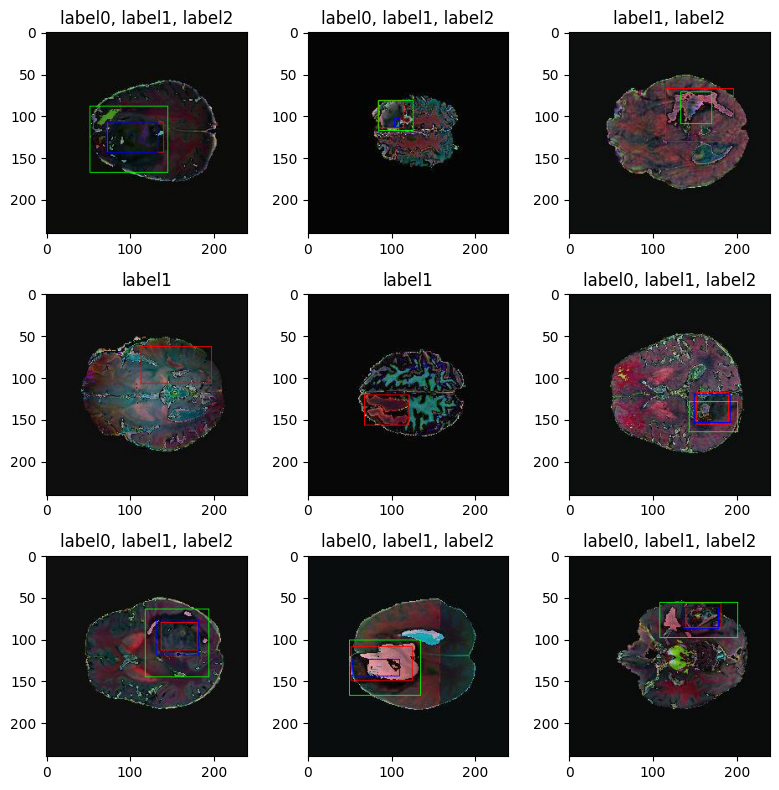

In [15]:
plot_random_images_bbox(image_paths=train_images, 
                        class_ids=train_class_ids, 
                        bboxes=train_bboxes,
                        class_map=class_map)

## Analyzing Imbalance 

In [ ]:
(classes, count) = np.unique(train_class_ids, return_counts=True)
classes, count

In [ ]:
np.unique(train_class_ids, return_counts=True)[0]

In [ ]:
class_labels = np.array([0, 1, 2])
class_counts = np.array([4338, 6836, 4122])

total_samples = sum(class_counts)
class_proportions = class_counts / total_samples

print("Class Proportions:", class_proportions)

In [ ]:
plt.pie(x=count, labels=class_map.values(),autopct='%1.1f%%')
plt.show()

## Rebalance dataset by Down sempling to dataset with min images

In [ ]:
del train_images, (train_class_ids, train_bboxes)

### Augmentation

In [ ]:
aug_rebal_train_images, aug_rebal_train_class_ids, aug_rebal_train_bboxes = prepare_train_dataset.rebalance_by_down_sampling_datasets(augment=True, plot=True)
len(aug_rebal_train_images), len(aug_rebal_train_class_ids), len(aug_rebal_train_bboxes)

In [ ]:
plot_random_images_bbox(image_paths=aug_rebal_train_images,
                        class_ids=aug_rebal_train_class_ids,
                        bboxes=aug_rebal_train_bboxes,
                        class_map=class_map)